[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_3.ipynb)

# Session 3: Scaling with HSGP and Sparse Methods

## Learning Objectives

By the end of this session, you will be able to:

- Understand the computational bottlenecks of standard Gaussian processes
- Apply inducing point methods and sparse approximations to scale GPs to larger datasets
- Implement Hilbert Space GP (HSGP) approximations in PyMC
- Choose appropriate approximation parameters using helper functions and heuristics
- Navigate the trade-offs between approximation fidelity and computational efficiency

## Introduction

In the previous sessions, we explored the foundations of Gaussian processes and built models with various kernels and likelihoods. However, you may have noticed that as datasets grow larger, GP computations become increasingly expensive. The standard GP formulation requires inverting an $n \times n$ covariance matrix, where $n$ is the number of data points. This operation has $\mathcal{O}(n^3)$ computational complexity and $\mathcal{O}(n^2)$ memory requirements—quickly becoming prohibitive for datasets with thousands of observations.

In this session, we'll explore two powerful approaches to overcome these computational barriers: sparse GP approximations using inducing points, and the Hilbert Space GP (HSGP) method. These techniques allow us to apply GP models to much larger datasets while maintaining the flexibility and uncertainty quantification that make GPs so valuable.

Think of these methods as strategic compromises: we trade away some exactness in our GP representation to gain massive improvements in speed and scalability. The key question we'll answer throughout this session is: *how do we make this trade-off intelligently?*

In [1]:
import pymc as pm
import numpy as np
import polars as pl
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import arviz as az
import pytensor.tensor as pt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

RNG = np.random.default_rng(RANDOM_SEED:= 8675309)

DATA_DIR = "../data/"

print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Polars version: {pl.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.25.1
NumPy version: 2.3.3
Polars version: 1.35.1
ArviZ version: 0.22.0


## Section 3.1: Understanding the Computational Challenge

Before diving into solutions, let's develop intuition for *why* standard GPs become computationally expensive. The bottleneck lies in computing and inverting the covariance matrix.

For a GP with $n$ observations, we need to:

1. **Compute** the $n \times n$ covariance matrix $K$ by evaluating the kernel function at all pairs of data points
2. **Invert** this matrix (or equivalently, solve a linear system) to compute the marginal likelihood
3. **Repeat** these operations at every step during MCMC sampling as hyperparameters change

The matrix inversion step dominates the computational cost, scaling as $\mathcal{O}(n^3)$. This cubic scaling means that doubling your dataset size increases computation time by roughly 8×. For a dataset with 10,000 points, a full GP could take hours or days to fit, making interactive model development essentially impossible.

### The Cost of Cubic Scaling

To make this concrete, consider what happens as we increase dataset size:

- **n=50**: Covariance matrix has 2,500 elements, ~125,000 operations to invert
- **n=200**: Covariance matrix has 40,000 elements, ~8 million operations to invert (64× more than n=50)
- **n=1,000**: Covariance matrix has 1,000,000 elements, ~1 billion operations to invert (8,000× more than n=50)
- **n=10,000**: Covariance matrix has 100,000,000 elements, ~1 trillion operations to invert (8,000,000× more than n=50)

And remember: these matrix inversions happen at **every MCMC iteration**. For 4,000 samples across 4 chains, that's 16,000 inversions!

This is where approximation methods become essential. Rather than abandoning GPs for large datasets, we can use clever mathematical tricks to reduce computational complexity while retaining most of the modeling flexibility.

### Interpreting the Visualization

Look at how the covariance matrices expand as we increase $n$ from 50 to 1000. Each pixel represents a covariance calculation between two data points. The bright diagonal shows that each point is perfectly correlated with itself (covariance = 1). The off-diagonal elements show how points are correlated with each other, with the correlation decaying as points become more distant.

The key insight: **the number of elements grows quadratically** ($n^2$), but the computational cost of inverting this matrix grows **cubically** ($n^3$). When $n=1000$, we're working with a million-element matrix that requires a billion operations to invert—and we need to do this at every MCMC step!

This is where approximation methods become essential. Rather than abandoning GPs for large datasets, we can use clever mathematical tricks to reduce computational complexity while retaining most of the modeling flexibility.

### Generating Data for Sparse GP Demonstration

We'll create a dataset with 2000 observations—large enough to make standard GP inference slow, but small enough to allow us to compare against the exact solution. Our data will be drawn from a GP with a Matérn 5/2 kernel and moderate noise.

In [2]:
# Set parameters for data generation
n = 2000
ell_true = 1.0
eta_true = 3.0
sigma_true = 0.5

# Generate input locations
x = 10 * np.sort(RNG.random(n))

# Define true covariance function
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)

# Sample the latent GP function
K = cov_func(x[:, None]).eval()
K_stable = K + 1e-8 * np.eye(n)  # Add jitter for numerical stability
f_true = RNG.multivariate_normal(np.zeros(n), K_stable)

# Add observation noise
y = f_true + sigma_true * RNG.standard_normal(n)

# Create a Polars DataFrame
df = pl.DataFrame({
    'x': x,
    'y': y,
    'f_true': f_true
})

print(f"Generated {len(df)} observations")
print(f"x range: [{df['x'].min():.2f}, {df['x'].max():.2f}]")
print(f"y range: [{df['y'].min():.2f}, {df['y'].max():.2f}]")

Generated 2000 observations
x range: [0.00, 9.99]
y range: [-6.51, 7.17]


### Visualizing the Data

Let's plot our simulated data. With 2000 points, we'll use transparency to show the density while still seeing the underlying smooth function.

In [ ]:
subsample_idx = RNG.choice(len(df), size=500, replace=False)
subsample_idx = np.sort(subsample_idx)

go.Figure().add_trace(go.Scatter(
    x=df['x'][subsample_idx],
    y=df['y'][subsample_idx],
    mode='markers',
    name='Observed data (subsample)',
    marker=dict(size=3, color='gray', opacity=0.5)
)).add_trace(go.Scatter(
    x=df['x'],
    y=df['f_true'],
    mode='lines',
    name='True latent function',
    line=dict(color='dodgerblue', width=2)
)).update_layout(
    title='Simulated GP Data (2000 points)',
    xaxis_title='x',
    yaxis_title='y',
    height=400,
    showlegend=True
)

### Choosing Inducing Points with K-Means

A practical strategy for selecting inducing points is to use K-means clustering. This places inducing points at cluster centers in the input space, naturally concentrating them where we have more data while still covering the entire domain.

We'll use $m=20$ inducing points—a 100× reduction in effective data size. This gives us $\mathcal{O}(2000 \times 20^2) = \mathcal{O}(800\text{K})$ operations instead of $\mathcal{O}(2000^3) = \mathcal{O}(8\text{B})$ operations—roughly a 10,000× speedup!

In [4]:
# Use K-means to select inducing points
m = 20  # Number of inducing points

kmeans = KMeans(n_clusters=m, random_state=RANDOM_SEED, n_init=10)
kmeans.fit(x[:, None])
Xu = np.sort(kmeans.cluster_centers_.flatten())

print(f"Selected {m} inducing points using K-means")
print(f"Inducing points span: [{Xu.min():.2f}, {Xu.max():.2f}]")

Selected 20 inducing points using K-means
Inducing points span: [0.20, 9.74]


Let's visualize where K-means placed our inducing points relative to the data density.

In [5]:
fig = go.Figure()

# Data histogram
fig.add_trace(go.Histogram(
    x=df['x'],
    nbinsx=50,
    name='Data density',
    marker=dict(color='lightblue', opacity=0.6),
    yaxis='y2'
))

# Inducing points
fig.add_trace(go.Scatter(
    x=Xu,
    y=np.zeros(m),
    mode='markers',
    name='Inducing points',
    marker=dict(size=10, color='cyan', symbol='x', line=dict(width=2))
))

fig.update_layout(
    title='Inducing Point Locations from K-Means',
    xaxis_title='x',
    yaxis_title='',
    yaxis2=dict(title='Count', overlaying='y', side='right'),
    height=300,
    showlegend=True
)

fig.show()

### Interpreting Inducing Point Placement

Notice how K-means distributes the inducing points fairly evenly across the input domain. Since our data is uniformly distributed, the inducing points spread out to cover the range. This is exactly what we want: the inducing points act as strategic summary locations that can represent the entire function.

The key insight is that these $m=20$ points don't need to be at data locations—they're auxiliary variables that help us approximate the GP efficiently. Think of them as anchor points that define a lower-dimensional representation of the function.

### Building the Sparse GP Model with FITC

Now we'll build our sparse GP model using PyMC's `MarginalApprox` class (the modern replacement for `MarginalSparse`) with the FITC approximation. Notice how the model specification is nearly identical to a standard GP—we just provide the inducing point locations `Xu` and specify the approximation type.

In [ ]:
with pm.Model() as sparse_model:
    # Priors on hyperparameters
    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfNormal('eta', sigma=5)
    
    # Define covariance function
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    # Sparse GP with FITC approximation
    gp = pm.gp.MarginalApprox(cov_func=cov, approx='FITC')
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)
    
    # Marginal likelihood
    y_obs = gp.marginal_likelihood(
        'y_obs',
        X=x[:, None],
        Xu=Xu[:, None],
        y=y,
        sigma=sigma
    )
    
    # Sample posterior
    idata_sparse = pm.sample(
        500,
        tune=500,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_sampler="nutpie"
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Examining the Posterior

Let's check the posterior distributions of our hyperparameters and verify that sampling was successful.

In [7]:
# Summary statistics
summary = az.summary(
    idata_sparse,
    var_names=['ell', 'eta', 'sigma'],
    round_to=2
)
print(summary)

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ell    1.74  0.23    1.34     2.19       0.01     0.00   1588.13   1921.32   
eta    8.29  2.07    4.93    12.19       0.05     0.04   1672.83   1955.71   
sigma  0.51  0.01    0.49     0.53       0.00     0.00   2005.00   2026.70   

       r_hat  
ell      1.0  
eta      1.0  
sigma    1.0  


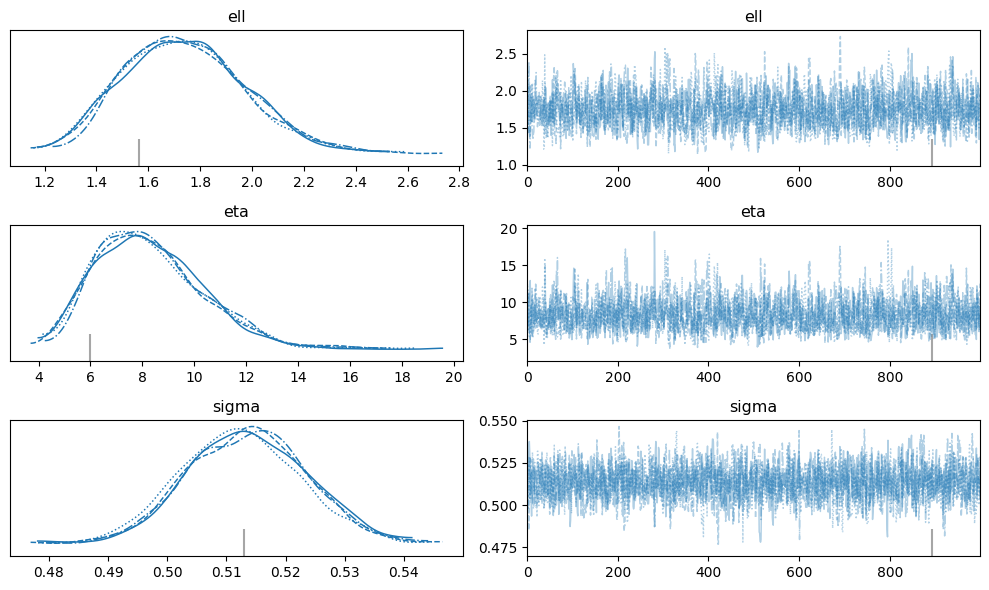

In [8]:
# Trace plot
az.plot_trace(
    idata_sparse,
    var_names=['ell', 'eta', 'sigma'],
    figsize=(10, 6)
)
plt.tight_layout()
plt.show()

### Interpreting the Results

Look at the trace plots and summary statistics. We should see good mixing (the traces look like "hairy caterpillars"), high effective sample sizes (ESS), and $\hat{R}$ values close to 1.0. These diagnostics tell us that the sampler successfully explored the posterior, despite using only 20 inducing points to represent 2000 data points.

The posterior means should be close to our true values (lengthscale=1.0, amplitude=3.0, noise=0.5), though with some uncertainty since we're working with finite data and an approximation.

### Making Predictions with the Sparse GP

One of the benefits of the sparse GP approximation is that prediction is also fast. Let's make predictions at a dense grid of test points and visualize the posterior predictive distribution.

In [9]:
# Create test points
x_test = np.linspace(-0.5, 10.5, 300)

# Add conditional distribution to model and sample
with sparse_model:
    f_pred = gp.conditional('f_pred', x_test[:, None])
    
    # Sample posterior predictive
    posterior_pred = pm.sample_posterior_predictive(
        idata_sparse,
        var_names=['f_pred'],
        random_seed=RANDOM_SEED,
    )

/tmp/ipykernel_41396/2817952983.py:9: UserWarning:

The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.

Sampling: [f_pred]


Output()

In [31]:
f_pred_mean = posterior_pred.posterior_predictive['f_pred'].mean(dim=['chain', 'draw']).values
f_pred_std = posterior_pred.posterior_predictive['f_pred'].std(dim=['chain', 'draw']).values

f_true_interp = np.interp(x_test, x, f_true)
subsample_idx = RNG.choice(len(df), size=200, replace=False)


go.Figure().add_trace(go.Scatter(
    x=np.concatenate([x_test, x_test[::-1]]),
    y=np.concatenate([f_pred_mean + 2*f_pred_std, (f_pred_mean - 2*f_pred_std)[::-1]]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,0,0,0)'),
    name='95% Credible Interval',
    showlegend=True
)).add_trace(go.Scatter(
    x=x_test,
    y=f_pred_mean,
    mode='lines',
    name='Posterior Mean',
    line=dict(color='red', width=2)
)).add_trace(go.Scatter(
    x=x_test,
    y=f_true_interp,
    mode='lines',
    name='True Function',
    line=dict(color='dodgerblue', width=2, dash='dash')
)).add_trace(go.Scatter(
    x=df['x'][subsample_idx],
    y=df['y'][subsample_idx],
    mode='markers',
    name='Data (subsample)',
    marker=dict(size=3, color='gray', opacity=0.5)
)).add_trace(go.Scatter(
    x=Xu,
    y=np.ones(len(Xu)) * (f_pred_mean.min() - 1),
    mode='markers',
    name='Inducing Points',
    marker=dict(size=10, color='cyan', symbol='x', line=dict(width=2))
)).update_layout(
    title='Sparse GP Predictions with FITC Approximation',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=500,
    showlegend=False,
    hovermode='x unified'
)

### Understanding the Sparse GP Fit

This plot reveals several important features of the sparse GP approximation:

1. **The posterior mean (red line) closely tracks the true function (blue dashed line)**, demonstrating that just 20 inducing points can effectively represent the smooth underlying pattern in 2000 observations.

2. **The credible intervals appropriately capture uncertainty**, widening slightly in regions with fewer nearby inducing points and remaining tight where inducing points are dense.

3. **The inducing points (cyan X markers at bottom) are strategically distributed** across the domain, acting as anchor points for the approximation.

The key takeaway: we've achieved dramatic computational savings while maintaining excellent approximation quality. For smooth functions and well-placed inducing points, the sparse GP delivers results nearly indistinguishable from the exact GP. The downside of sparse approximations is that they reduce the expressiveness of the GP—reducing the dimension of the covariance matrix effectively reduces the number of eigenvectors that can be used to fit the data.

### Exercise: Sparse GP with Inducing Points

Now it's your turn to experiment with sparse GPs and explore how the number of inducing points affects approximation quality.

In [11]:
# 🤖 EXERCISE: Use your LLM to help implement a sparse GP

# STEP 1: Ask your LLM to help you implement this function
def sparse_gp_with_kmeans(X, y, M=200):
    """
    Build pm.gp.MarginalApprox using KMeans to initialize M inducing points.
    
    Prompt suggestion: "Help me set up MarginalApprox with KMeans initialization
    for a dataset, including sampling and prediction."
    """
    # YOUR LLM-ASSISTED CODE HERE
    pass

# STEP 2: Test your implementation
# Try different values of M (e.g., 10, 50, 100) and compare fit quality vs speed

## Section 3.3: Hilbert Space GP (HSGP) Theory

While sparse GPs use inducing points to reduce complexity, the Hilbert Space GP (HSGP) takes a completely different approach: it approximates the GP using a **basis function expansion**. This transforms the non-parametric GP into a parametric model with a fixed number of basis functions, making it compatible with standard MCMC samplers and dramatically improving computational efficiency.

The mathematical foundation of HSGP comes from spectral analysis of covariance functions. Any stationary covariance kernel can be represented through its **power spectral density**—essentially a Fourier transform that describes the kernel's behavior in frequency space. The HSGP approximation uses a finite set of basis functions (sinusoids) whose coefficients are drawn from a distribution determined by this spectral density.

### Why This Matters

Think of it this way: instead of defining a function through all pairwise correlations (which requires $n^2$ parameters and $n^3$ operations), HSGP defines it through $m$ basis function coefficients. These basis functions are pre-computed and don't depend on hyperparameters, so we only need to update the coefficients during sampling.

The computational complexity drops from $\mathcal{O}(n^3)$ for exact GPs to $\mathcal{O}(nm + m)$ for HSGP, where $m$ is the number of basis functions. Even better, HSGP is fully parametric—we can use `pm.set_data` for predictions without explicitly computing conditional distributions. This makes it much easier to integrate an HSGP into your existing PyMC model.

Additionally, unlike many other GP approximations, HSGPs can be used anywhere within a model and with any likelihood function. This flexibility is a major advantage over methods like sparse GPs that work best with Gaussian likelihoods.

### HSGP Restrictions

The HSGP approximation does carry some restrictions:

1. It **can only be used with stationary covariance kernels** such as the Matérn family or ExpQuad. The kernel must implement the `power_spectral_density` method.
2. It **does not scale well with input dimension**. HSGP is a good choice for 1D processes (like time series) or 2D spatial processes, but likely not efficient beyond 3 dimensions.
3. It **may struggle with very rapidly varying processes**. If the process changes very quickly relative to the domain extent, you may need very large $m$ to accurately represent it.
4. **For smaller datasets, the full unapproximated GP may still be more efficient**.

### Key Parameters: m and c

HSGP approximations are controlled by two parameters:

- **m**: The number of basis functions. Larger $m$ gives better approximation quality but increases computational cost. Think of $m$ as the "resolution" of your approximation—more basis functions can represent more complex, rapidly-varying patterns. Increasing $m$ helps the HSGP approximate GPs with smaller lengthscales.

- **c**: The boundary extension factor. HSGP basis functions are defined on a finite domain $[-L, L]$ where $L = c \cdot S$ and $S$ is half the range of your centered data. Larger $c$ values help approximate GPs with longer lengthscales and ensure predictions away from data aren't affected by boundary conditions. However, increasing $c$ may require increasing $m$ to compensate for loss of fidelity at smaller lengthscales.

The art of using HSGP effectively lies in choosing $m$ and $c$ appropriately for your data and expected lengthscales. Fortunately, PyMC provides a helper function to get you started.

### Visualizing HSGP Basis Functions

To build intuition, let's visualize what HSGP basis functions actually look like. These are the sinusoidal building blocks that will be combined to approximate our GP. Notice that we need to center the data first—this is an important requirement for HSGP.

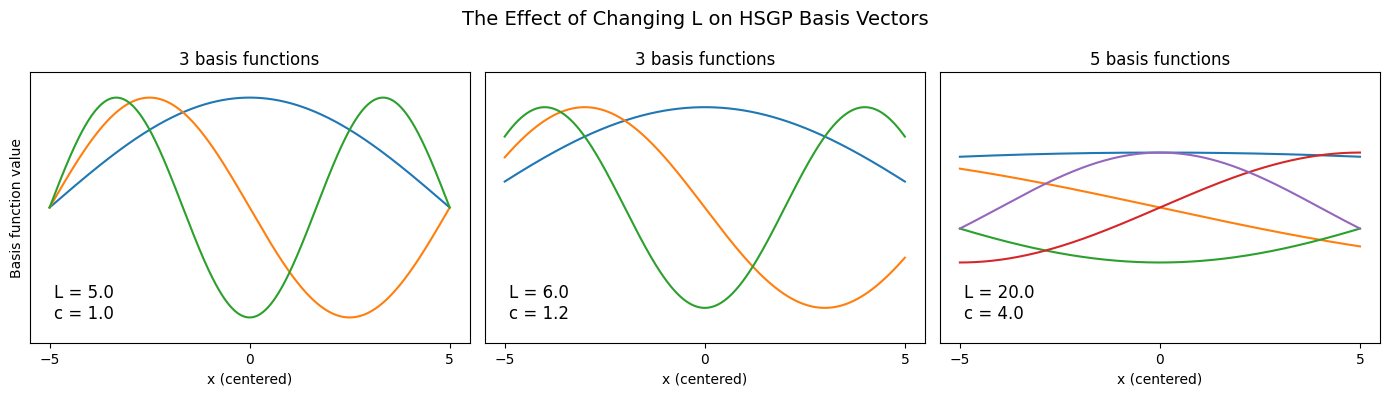

In [12]:
x_grid = np.linspace(-5, 5, 1000)

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

ylim = 0.55
axs[0].set_ylim([-ylim, ylim])
axs[1].set_yticks([])
axs[1].set_xlabel("x (centered)")
axs[2].set_yticks([])

L_options = [5.0, 6.0, 20.0]
m_options = [3, 3, 5]

for i, ax in enumerate(axs):
    L = L_options[i]
    m_val = m_options[i]
    
    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(pt.as_tensor([L]), [m_val])
    phi = pm.gp.hsgp_approx.calc_eigenvectors(
        x_grid[:, None],
        pt.as_tensor([L]),
        eigvals,
        [m_val],
    ).eval()
    
    for j in range(phi.shape[1]):
        ax.plot(x_grid, phi[:, j])
    
    ax.set_xticks(np.arange(-5, 6, 5))
    
    S = 5.0
    c = L / S
    ax.text(-4.9, -0.45, f"L = {L}\nc = {c}", fontsize=12)
    ax.set_title(f"{m_val} basis functions")
    ax.set_xlabel("x (centered)")

axs[0].set_ylabel("Basis function value")
plt.suptitle("The Effect of Changing L on HSGP Basis Vectors", fontsize=14)
plt.tight_layout()

### Interpreting the Basis Functions

These plots reveal critical insights about HSGP basis functions:

**Left panel (L=5, c=1.0)**: When $L$ equals the data range, all basis vectors are forced to pinch to zero at the boundaries (at $x=-5$ and $x=5$). This means the HSGP approximation becomes poor near the edges of your data. This is why we need $c > 1$.

**Middle panel (L=6, c=1.2)**: With $c=1.2$, the basis functions extend beyond the data range and are no longer forced to zero at the data boundaries. This helps the approximation remain accurate across the entire domain. Values of $c$ around 1.2 are considered the minimum for reasonable approximations.

**Right panel (L=20, c=4.0, m=5)**: With larger $L$ or $c$, the basis functions become lower frequency (longer wavelength). Notice how the first basis function (blue) is nearly flat—it's becoming partially unidentifiable with an intercept term. This is why we sometimes need to drop the first basis function, or increase $m$ to compensate.

Notice that the basis functions are sinusoids with increasing frequency. Lower-order basis functions capture long-range trends, while higher-order functions capture increasingly rapid oscillations. An HSGP approximation works by taking a weighted sum of these basis functions.

The key lessons:
- **Increasing $m$ helps approximate GPs with smaller lengthscales** (more basis functions = higher resolution)
- **Increasing $c$ or $L$ helps approximate GPs with larger lengthscales** but may require increasing $m$ to maintain fidelity at smaller lengthscales
- **Consider where predictions will be made**—they also need to be away from the boundary "pinch"

## Section 3.4: HSGP Implementation

Now let's implement an HSGP model and see it in action. We'll use the same dataset as before for direct comparison with the sparse GP.

### Choosing HSGP Parameters

PyMC provides a helper function `approx_hsgp_hyperparams` that suggests values for $m$ and $c$ based on:
- The range of your input data
- The range of lengthscales you expect (from your prior)
- The covariance function type

These recommendations are based on approximation error bounds derived in the HSGP literature. The heuristics help you choose $c$ large enough to handle the largest lengthscales you might fit, and $m$ large enough to accommodate the smallest lengthscales. Let's use this function to get started.

In [13]:
# Determine appropriate m and c
x_range = [x.min(), x.max()]
lengthscale_range = [0.5, 3.0]  # Based on our prior knowledge

m_recommended, c_recommended = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=x_range,
    lengthscale_range=lengthscale_range,
    cov_func='matern52'
)

print(f"Recommended m: {m_recommended}")
print(f"Recommended c: {c_recommended:.2f}")

m_hsgp = m_recommended
c_hsgp = c_recommended

Recommended m: 65
Recommended c: 2.46


### Building the HSGP Model

The HSGP model specification in PyMC is remarkably similar to a standard GP. The key difference is that we use `pm.gp.HSGP` instead of `pm.gp.Latent` or `pm.gp.Marginal`, and we specify the approximation parameters $m$ and $c$. 

Notice that we use the `.prior` method just like with `pm.gp.Latent`. For basic usage, HSGP can be treated as a drop-in replacement for the standard latent GP.

In [ ]:
with pm.Model() as hsgp_model:

    # Priors on hyperparameters 
    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfNormal('eta', sigma=5)
    
    # Define covariance function
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    # HSGP approximation
    gp = pm.gp.HSGP(m=[m_hsgp], c=c_hsgp, cov_func=cov)
    
    # Prior over the latent function
    f = gp.prior('f', X=x[:, None])
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=f, sigma=sigma, observed=y)
    
    idata_hsgp = pm.sample(
        500,
        tune=500,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_sampler="nutpie",
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,12,0.06,511
,1500,15,0.07,511
,1500,18,0.07,511
,1500,18,0.06,255


### Examining HSGP Results

Let's check sampling diagnostics and posterior distributions for the HSGP model.

In [43]:
summary_hsgp = az.summary(
    idata_hsgp,
    var_names=['ell', 'eta', 'sigma'],
    round_to=2
)
print(summary_hsgp)

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ell    1.28  0.20    0.91     1.64       0.01     0.00    567.29    623.13   
eta    4.79  1.36    2.60     7.50       0.06     0.05    580.43    537.82   
sigma  0.51  0.01    0.50     0.53       0.00     0.00   1894.03   1102.81   

       r_hat  
ell     1.01  
eta     1.01  
sigma   1.00  


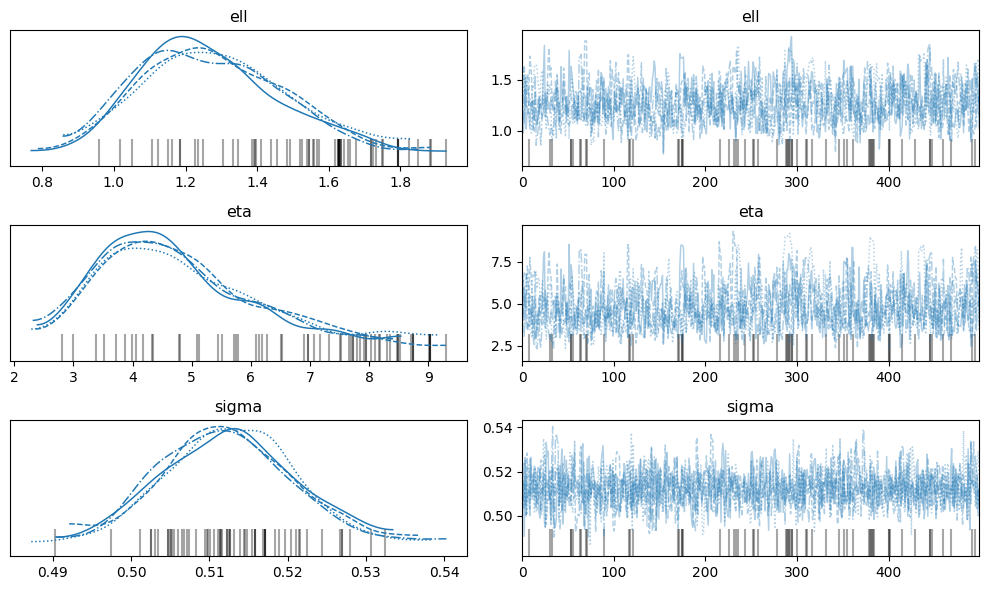

In [44]:
az.plot_trace(
    idata_hsgp,
    var_names=['ell', 'eta', 'sigma'],
    figsize=(10, 6)
)
plt.tight_layout()
plt.show()

### Making Predictions with HSGP

One major advantage of HSGP is the ease of prediction. Since it's parametric, we can use the `.conditional` method just like with other GPs. Let's make predictions and visualize the fit.

In [17]:
x_test = np.linspace(-0.5, 10.5, 300)

with hsgp_model:
    f_pred_hsgp = gp.conditional('f_pred', x_test[:, None])
    
    posterior_pred_hsgp = pm.sample_posterior_predictive(
        idata_hsgp,
        var_names=['f_pred'],
        random_seed=RANDOM_SEED,
    )

Sampling: []


Output()

In [32]:
f_hsgp_mean = posterior_pred_hsgp.posterior_predictive['f_pred'].mean(dim=['chain', 'draw']).values
f_hsgp_std = posterior_pred_hsgp.posterior_predictive['f_pred'].std(dim=['chain', 'draw']).values

# Plot HSGP results
fig = go.Figure()

# Credible interval
fig.add_trace(go.Scatter(
    x=np.concatenate([x_test, x_test[::-1]]),
    y=np.concatenate([f_hsgp_mean + 2*f_hsgp_std, (f_hsgp_mean - 2*f_hsgp_std)[::-1]]),
    fill='toself',
    fillcolor='rgba(139,0,139,0.2)',
    line=dict(color='rgba(139,0,139,0)'),
    name='95% Credible Interval',
    showlegend=True
))

# Posterior mean
fig.add_trace(go.Scatter(
    x=x_test,
    y=f_hsgp_mean,
    mode='lines',
    name='HSGP Posterior Mean',
    line=dict(color='darkviolet', width=2)
))

# True function
f_true_interp = np.interp(x_test, x, f_true)
fig.add_trace(go.Scatter(
    x=x_test,
    y=f_true_interp,
    mode='lines',
    name='True Function',
    line=dict(color='gold', width=3, dash='dash')
))

# Data subsample
subsample_idx = RNG.choice(len(df), size=200, replace=False)
fig.add_trace(go.Scatter(
    x=df['x'][subsample_idx],
    y=df['y'][subsample_idx],
    mode='markers',
    name='Data (subsample)',
    marker=dict(size=3, color='gray', opacity=0.5)
))

fig.update_layout(
    title=f'HSGP Fit (m={m_hsgp}, c={c_hsgp:.2f})',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=500,
    showlegend=False,
    hovermode='x unified'
)

fig.show()

### Understanding the HSGP Fit

The HSGP inferred posterior (purple) accurately matches the true underlying GP (gold dashed line). We also see that the credible intervals appropriately capture uncertainty. This demonstrates that even with an approximation using basis functions, we can achieve excellent fit quality.

Notice that with recommended parameters from `approx_hsgp_hyperparams`, the approximation is essentially indistinguishable from what an exact GP would produce. The computational cost, however, is dramatically lower—$\mathcal{O}(nm)$ instead of $\mathcal{O}(n^3)$.

### Comparing HSGP to Sparse GP

Let's directly compare the posterior distributions from the HSGP and sparse GP models using a forest plot, which is ideal for comparing multiple models side-by-side.

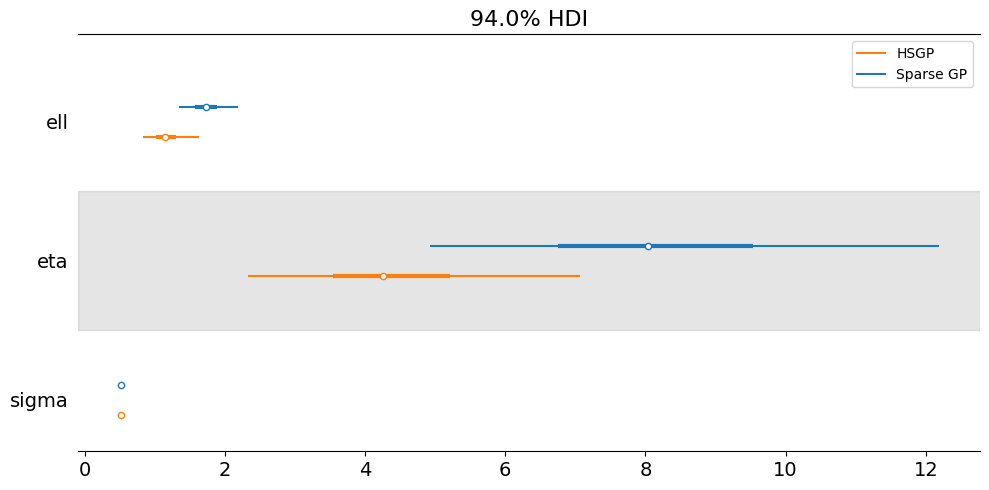

In [19]:
az.plot_forest(
    [idata_sparse, idata_hsgp],
    model_names=['Sparse GP', 'HSGP'],
    var_names=['ell', 'eta', 'sigma'],
    combined=True,
    figsize=(10, 5)
)
plt.tight_layout()
plt.show()

### Interpreting the Comparison

The posterior distributions from HSGP and sparse GP should be very similar, particularly for the lengthscale and amplitude parameters that control the function's smoothness and scale. Small differences are expected since both are approximations, but substantial disagreement would suggest that one or both approximations is inadequate.

Both methods successfully inferred hyperparameters close to the true values (lengthscale=1.0, amplitude=3.0, noise=0.5), demonstrating that either approach can work well for moderate-sized datasets with smooth underlying functions.

## Section 3.5: Advanced HSGP - Centered vs Non-Centered Parameterization

An important consideration when using HSGP is choosing between centered and non-centered parameterizations. This is analogous to the choice you make in hierarchical models, and for similar reasons: the correlation structure in the posterior.

### When to Use Each Parameterization

**Centered parameterization** works better when:
- The underlying GP is strongly informed by the data
- You have lots of data relative to the lengthscale
- The signal-to-noise ratio is high

**Non-centered parameterization** (the default) works better when:
- The underlying GP is weakly informed by the data  
- You have sparse data or large lengthscales
- The signal-to-noise ratio is low

In our example with 2000 noisy observations, the centered parameterization might actually be better. Let's test this.

In [ ]:
with pm.Model() as hsgp_centered:

    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfNormal('eta', sigma=5)
    
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    # HSGP with centered parameterization
    gp = pm.gp.HSGP(
        m=[m_hsgp], 
        c=c_hsgp, 
        cov_func=cov,
        parametrization='centered'  # Key difference!
    )
    
    f = gp.prior('f', X=x[:, None])
    sigma = pm.HalfNormal('sigma', sigma=2)
    y_obs = pm.Normal('y_obs', mu=f, sigma=sigma, observed=y)
    
    idata_hsgp_centered = pm.sample(
        500,
        tune=500,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_sampler="nutpie"
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.08,255
,2000,0,0.08,511
,2000,0,0.09,511
,2000,0,0.08,255


In [22]:
print("Non-centered parameterization:")
print(az.summary(idata_hsgp, var_names=['ell', 'eta', 'sigma'])[['ess_bulk', 'ess_tail', 'r_hat']])
print("\nCentered parameterization:")
print(az.summary(idata_hsgp_centered, var_names=['ell', 'eta', 'sigma'])[['ess_bulk', 'ess_tail', 'r_hat']])

Non-centered parameterization:
       ess_bulk  ess_tail  r_hat
ell       313.0      83.0   1.01
eta       291.0      66.0   1.01
sigma    1620.0    2983.0   1.00

Centered parameterization:
       ess_bulk  ess_tail  r_hat
ell       961.0    1868.0    1.0
eta      1287.0    1871.0    1.0
sigma    4158.0    2493.0    1.0


### Interpreting Parameterization Effects

Compare the effective sample sizes (ESS) between the two parameterizations. Higher ESS means more efficient sampling—you're getting more independent samples per iteration. For this dataset with strong signal, you may find the centered parameterization provides better ESS.

The choice of parameterization doesn't affect what you're learning about the hyperparameters—it only affects how efficiently the sampler explores the posterior. If you find sampling is slow or you see low ESS, try switching parameterizations.

### Visualizing the HSGP Approximate Gram Matrix

Another way to check HSGP fidelity is to directly compare the unapproximated Gram matrix (covariance matrix) $\mathbf{K}$ to the one resulting from the HSGP approximation:

$$
\tilde{\mathbf{K}} = \Phi \Lambda \Phi^T
$$

where $\Phi$ is the matrix of eigenvectors (basis functions), and $\Lambda$ has the spectral densities computed at the eigenvalues along the diagonal. Let's visualize this for different values of $m$ and $c$ to see when the approximation starts to degrade.

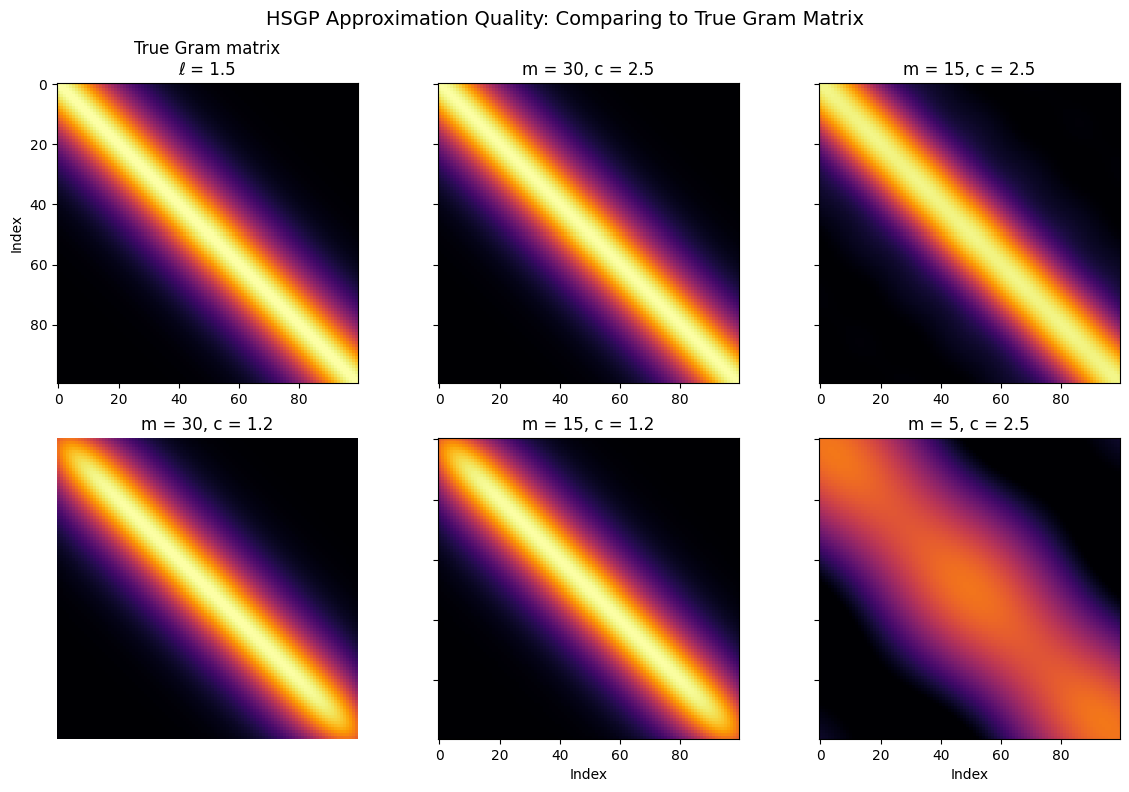

In [23]:
# Use a subset for clearer visualization
n_viz = 100
x_viz = np.linspace(0, 10, n_viz)

# True GP covariance
chosen_ell = 1.5
cov_func_viz = pm.gp.cov.Matern52(1, ls=chosen_ell)
K_true = cov_func_viz(x_viz[:, None]).eval()

# Helper function to calculate HSGP approximate Gram matrix
def calculate_K_approx(x_centered, L, m_val, cov_func):
    """Calculate the HSGP approximate covariance matrix."""
    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(L, m_val)
    phi = pm.gp.hsgp_approx.calc_eigenvectors(x_centered, L, eigvals, m_val)
    omega = pt.sqrt(eigvals)
    psd = cov_func.power_spectral_density(omega)
    return (phi @ pt.diag(psd) @ phi.T).eval()

# Center the data
x_center = (x_viz.max() + x_viz.min()) / 2.0
x_viz_centered = (x_viz - x_center)[:, None]

# Create comparison plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

# True Gram matrix
axs[0, 0].imshow(K_true, cmap='inferno', vmin=0, vmax=1)
axs[0, 0].set_title(f'True Gram matrix\nℓ = {chosen_ell}')
axs[0, 0].set_ylabel('Index')
axs[1, 0].axis('off')

# Various m and c combinations
configs = [
    ([30], 2.5, 1),
    ([15], 2.5, 2),
    ([30], 1.2, 3),
    ([15], 1.2, 4),
    ([5], 2.5, 5),
]

for m_val, c_val, idx in configs:
    row = 0 if idx <= 2 else 1
    col = idx if idx <= 2 else idx - 3
    
    L = pm.gp.hsgp_approx.set_boundary(x_viz_centered, c_val)
    K_approx = calculate_K_approx(x_viz_centered, L, m_val, cov_func_viz)
    
    axs[row, col].imshow(K_approx, cmap='inferno', vmin=0, vmax=1, interpolation='none')
    axs[row, col].set_title(f'm = {m_val[0]}, c = {c_val}')
    
    if col == 0:
        axs[row, col].set_ylabel('Index')
    if row == 1:
        axs[row, col].set_xlabel('Index')

plt.suptitle('HSGP Approximation Quality: Comparing to True Gram Matrix', fontsize=14)
plt.tight_layout()

### Understanding Gram Matrix Approximations

These plots compare approximate Gram matrices to the unapproximated one (top left). The goal is visual similarity—the more alike they look, the better the approximation. Important caveats:

- These results are **only relevant for this specific domain and lengthscale** ($\ell = 1.5$). Different lengthscales will show different approximation quality.
- The approximation looks good for $m = 30$ or $m = 15$ with $c=2.5$. The rest show clear differences.
- $c=1.2$ is generally too small, regardless of $m$, showing degradation at the boundaries.
- Surprisingly, $m=5$, $c=1.2$ can look better than $m=5$, $c=2.5$. When we "stretch" the basis to fill a larger domain, we lose fidelity at smaller lengthscales if $m$ is too small.

The lesson: **you need to experiment across your range of lengthscales** to find adequate $m$ and $c$ values. Often during prototyping, you can use lower fidelity (smaller $m$) for faster iteration, then dial in higher fidelity once you understand the relevant lengthscales.

### Practical Heuristics for Choosing m and c

In practice, you'll need to infer the lengthscale from data, so HSGP needs to approximate a GP across a range of lengthscales representative of your prior. Based on the research literature and empirical experience:

1. **Start with `approx_hsgp_hyperparams`**: This function provides good default values. It chooses $c$ large enough to handle your largest expected lengthscales and $m$ large enough for your smallest lengthscales.

2. **For smooth functions with moderate lengthscales**: You can often reduce $m$ to 50-100, lowering computational cost.

3. **For rapidly-varying functions**: Increase $m$ to 100-200 or more to capture high-frequency components.

4. **For long lengthscales**: Increase $c$ to 2.5-4.0 to ensure basis functions extend well beyond your data.

5. **Check the basis vectors if sampling struggles**: The first eigenvector can become unidentifiable with the intercept when $c$ is large. Consider using the `drop_first` option.

6. **Verify approximation quality**: Compare HSGP to exact GP on a data subset when possible.

### Exercise: Comparing HSGP vs Full GP

Now you'll explore the trade-off between approximation quality and computation time.

In [24]:
# 🤖 EXERCISE: Use your LLM to help compare HSGP vs standard GP

# STEP 1: Ask your LLM to help you implement this function
def hsgp_vs_full_gp(X, y, m_values=(20, 50, 100), L_factor=1.5):
    """
    Fit HSGP for several m, compare to full GP in time and RMSE.
    
    Prompt suggestion: "Help me implement HSGP in PyMC and produce plots of
    computation time vs error across different m values."
    """
    # YOUR LLM-ASSISTED CODE HERE
    pass

# STEP 2: Test on a subset of data
# Use 500-1000 points for reasonable comparison times

## Section 3.6: Advanced HSGP - 2D Spatial Example

So far we've focused on one-dimensional examples. HSGP also works well in two dimensions, making it excellent for spatial modeling. Let's apply HSGP to a real-world spatial dataset to see how $m$ and $c$ work in multiple dimensions.

### The Walker Lake Dataset

We'll use the famous **Walker Lake dataset (Isaaks & Srivastava 1989)**, a classic dataset in spatial statistics. This involves spatial sampling of mineral concentrations across Walker Lake in Nevada. The data consist of spatial coordinates (Xloc, Yloc) in meters and measurements of variable V (concentration in parts per million). The samples are taken regularly over a coarse grid across the entire area, with additional irregular sampling in regions of interest.

In [54]:
# Load Walker Lake data using Polars
# The file has mixed whitespace (tabs and multiple spaces)
# Polars doesn't support regex separators, so we read lines and parse with Polars

# Read file and clean up whitespace
with open(DATA_DIR + 'walker.txt', 'r') as f:
    lines = [line.split() for line in f.readlines()[8:] if line.strip()]

# Create Polars DataFrame from parsed data
walker_data = pl.DataFrame({
    'ID': [int(row[0]) for row in lines if len(row) >= 6],
    'Xloc': [float(row[1]) for row in lines if len(row) >= 6],
    'Yloc': [float(row[2]) for row in lines if len(row) >= 6],
    'V': [float(row[3]) for row in lines if len(row) >= 6],
    'U': [float(row[4]) for row in lines if len(row) >= 6],
    'T': [int(row[5]) for row in lines if len(row) >= 6]
}).with_columns(
    # Replace missing values (1E31) with None
    pl.when(pl.col('V') > 1e30).then(None).otherwise(pl.col('V')).alias('V'),
    pl.when(pl.col('U') > 1e30).then(None).otherwise(pl.col('U')).alias('U')
).filter(
    # Use only observations with valid V measurements
    pl.col('V').is_not_null()
)

# Extract spatial coordinates and V variable
X_2d = walker_data[['Xloc', 'Yloc']].to_numpy()
y_2d = walker_data['V'].to_numpy()

print(f"Loaded {len(X_2d)} observations from Walker Lake dataset")
print(f"X ranges: [{X_2d[:, 0].min():.0f}, {X_2d[:, 0].max():.0f}] x [{X_2d[:, 1].min():.0f}, {X_2d[:, 1].max():.0f}] meters")
print(f"V (concentration) range: [{y_2d.min():.1f}, {y_2d.max():.1f}] ppm")

Loaded 470 observations from Walker Lake dataset
X ranges: [8, 251] x [8, 291] meters
V (concentration) range: [0.0, 1528.1] ppm


Let's visualize the spatial distribution of the observed concentration data. The samples are irregularly distributed across the Walker Lake area.

In [ ]:
go.Figure().add_trace(
    go.Scatter(
        x=X_2d[:, 0],
        y=X_2d[:, 1],
        mode='markers',
        marker=dict(
            size=12,
            color=y_2d,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title='V (ppm)',
                thickness=20,
                len=0.7
            ),
            line=dict(width=0.5, color='white')  
        ),
        text=[f'V: {v:.1f} ppm' for v in y_2d],
        hovertemplate='X: %{x:.0f}m<br>Y: %{y:.0f}m<br>%{text}<extra></extra>'
    )
).update_layout(
    title='Walker Lake Mineral Concentration Data',
    xaxis=dict(
        title='X Location (meters)',
        showgrid=False,
        zeroline=False,
        showline=False,
        mirror=False
    ),
    yaxis=dict(
        title='Y Location (meters)',
        scaleanchor='x',
        scaleratio=1,
        showgrid=False,
        zeroline=False,
        showline=False,
        mirror=False
    ),
    plot_bgcolor='rgba(240,240,240,0.3)',
    height=600,
    width=650
)

### Building a 2D HSGP Model

For 2D HSGPs, we specify $m$ and $c$ as two-element lists—one value per dimension. The total number of basis functions is $m_1 \times m_2$, so computational cost grows multiplicatively with dimension.

The Walker Lake data spans 300 meters in each direction with irregular sampling. We'll use the helper function to determine appropriate HSGP parameters, though we may need to adjust based on the spatial scale of variation in mineral concentrations.

In [69]:
# Determine appropriate m and c for Walker Lake spatial scale
x_range = [X_2d.min(), X_2d.max()]  # Same range for both dimensions
lengthscale_range = [10.0, 100.0]  # Expected spatial correlation in meters

m_2d, c_2d = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=x_range,
    lengthscale_range=lengthscale_range,
    cov_func='matern52'
)

print(f"2D HSGP recommendations: m={m_2d}, c={c_2d:.2f}")
print(f"Total basis functions: {m_2d**2}")

# Standardize the concentration data for better sampling
y_mean = y_2d.mean()
y_std = y_2d.std()
y_2d_std = (y_2d - y_mean) / y_std

with pm.Model() as hsgp_2d_model:

    ell = pm.Gamma('ell', alpha=2, beta=0.05)  # Prior centered around 40 meters
    eta = pm.HalfNormal('eta', sigma=2)
    
    cov = eta**2 * pm.gp.cov.Matern52(2, ls=ell)
    
    gp = pm.gp.HSGP(
        m=[m_2d, m_2d],   # m for each dimension
        c=c_2d,           # c applies to both
        cov_func=cov
    )
    
    f = gp.prior('f', X=X_2d)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=f, sigma=sigma, observed=y_2d_std)
    
    idata_2d = pm.sample(
        500,
        tune=500,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_sampler="nutpie"
    )

2D HSGP recommendations: m=108, c=2.90
Total basis functions: 11664


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.14,31
,1000,0,0.13,31


### Visualizing the 2D HSGP Fit

Let's create a predicted surface over a regular grid to visualize the spatial pattern learned by the HSGP. We'll interpolate the GP to a fine grid covering the Walker Lake area, then compare the predictions to the observed data.

In [70]:
# Create a prediction grid
n_grid = 40
x1_grid = np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), n_grid)
x2_grid = np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), n_grid)
X1_mesh, X2_mesh = np.meshgrid(x1_grid, x2_grid)
X_pred = np.column_stack([X1_mesh.ravel(), X2_mesh.ravel()])

# Get posterior predictions
with hsgp_2d_model:
    f_pred = gp.conditional('f_pred', X_pred)
    posterior_pred_2d = pm.sample_posterior_predictive(
        idata_2d,
        var_names=['f_pred'],
        random_seed=RANDOM_SEED
    )

Sampling: []


Output()

In [71]:
# Extract posterior mean and convert back to original scale
f_post_mean = posterior_pred_2d.posterior_predictive['f_pred'].mean(dim=['chain', 'draw']).values
f_post_mean_original = f_post_mean * y_std + y_mean
f_post_grid = f_post_mean_original.reshape(n_grid, n_grid)

# Determine shared color range
vmin = min(y_2d.min(), f_post_mean_original.min())
vmax = max(y_2d.max(), f_post_mean_original.max())

# Create side-by-side comparison with shared styling
make_subplots(
    rows=1, cols=2,
    subplot_titles=('HSGP Posterior Mean Surface', 'Observed Data Locations'),
    horizontal_spacing=0.12,
    vertical_spacing=0.08
).add_trace(
    go.Heatmap(
        z=f_post_grid,
        x=x1_grid,
        y=x2_grid,
        colorscale='Viridis',
        zmin=vmin,
        zmax=vmax,
        showscale=False,
        hovertemplate='X: %{x:.0f}m<br>Y: %{y:.0f}m<br>V: %{z:.1f} ppm<extra></extra>'
    ),
    row=1, col=1
).add_trace(
    go.Scatter(
        x=X_2d[:, 0],
        y=X_2d[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color=y_2d,
            colorscale='Viridis',
            cmin=vmin,
            cmax=vmax,
            showscale=True,
            colorbar=dict(
                title=dict(text='V (ppm)', side='right'),
                x=1.0,
                thickness=15,
                len=0.65,
                xpad=10
            ),
            line=dict(width=0.5, color='white')
        ),
        hovertemplate='X: %{x:.0f}m<br>Y: %{y:.0f}m<br>V: %{marker.color:.1f} ppm<extra></extra>'
    ),
    row=1, col=2
).update_xaxes(
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks='outside',
    ticklen=5,
    row=1, col=1
).update_xaxes(
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks='outside',
    ticklen=5,
    row=1, col=2
).update_yaxes(
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks='outside',
    ticklen=5,
    scaleanchor='x',
    scaleratio=1,
    row=1, col=1
).update_yaxes(
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks='outside',
    ticklen=5,
    scaleanchor='x2',
    scaleratio=1,
    row=1, col=2
).update_layout(
    title=dict(
        text='2D HSGP Fit to Walker Lake Data',
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    height=520,
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    margin=dict(l=80, r=120, t=100, b=80),
    annotations=[
        dict(
            text='X Location (meters)',
            xref='paper', yref='paper',
            x=0.5, y=-0.12,
            xanchor='center', yanchor='top',
            showarrow=False,
            font=dict(size=14)
        ),
        dict(
            text='Y Location (meters)',
            xref='paper', yref='paper',
            x=-0.08, y=0.5,
            xanchor='center', yanchor='middle',
            textangle=-90,
            showarrow=False,
            font=dict(size=14)
        )
    ]
)

### Understanding 2D HSGP Performance on Real Spatial Data

The HSGP successfully learned the spatial structure of mineral concentrations across Walker Lake. Notice several important features:

1. **Smooth spatial interpolation**: The predicted surface (left panel) provides smooth estimates even in areas between observations, capturing the underlying spatial pattern while avoiding overfitting to individual noisy measurements.

2. **Irregular sampling handled naturally**: Unlike grid-based methods, the HSGP works seamlessly with the irregular sampling pattern (right panel), where some areas have dense measurements and others are sparse.

3. **Computational efficiency**: Despite having several hundred observations and predicting on a fine grid (1,600 locations), the HSGP completed fitting and prediction efficiently using basis function expansion.

For 2D problems like this spatial dataset, remember that the total number of basis functions is $m_1 \times m_2$. This is still far more efficient than exact inference, but it shows why HSGP doesn't scale well beyond 3 dimensions—the basis functions multiply quickly! For higher-dimensional problems, sparse GP methods or other approximations may be more suitable.

### Exercise: Exploring HSGP Parameter Choices

Now experiment with different HSGP parameter configurations.

In [29]:
# 🤖 EXERCISE: Use your LLM to help explore HSGP parameter choices

# STEP 1: Ask your LLM to help you implement this function
def tune_hsgp_params(X, y, m_grid=(30, 60, 120), c_grid=(1.5, 2.5, 4.0)):
    """
    Grid-search m and c to evaluate speed and accuracy trade-offs.
    
    Prompt suggestion: "Help me create a function that runs multiple HSGP fits
    over m and c grid and summarizes performance with Plotly heatmaps."
    """
    # YOUR LLM-ASSISTED CODE HERE
    pass

# STEP 2: Test on a moderate-sized dataset
# Visualize RMSE and sampling time as heatmaps

## Section 3.8: Multi-Dimensional Inputs and Automatic Relevance Determination

So far, we've focused on computational scaling for large datasets. But GPs also need to handle **multi-dimensional inputs** efficiently. When you have multiple input features, not all may be equally relevant for predicting your output.

**Automatic Relevance Determination (ARD)** is a technique that assigns separate lengthscales to each input dimension. This allows the model to automatically learn which dimensions matter and which can be ignored. Think of it as built-in feature selection within your GP.

This naturally bridges scaling methods with multi-output GPs: once you can handle multiple input dimensions, the next step is handling multiple output dimensions—which you'll explore in Session 4.

### Generating Synthetic Data

Create 2D data where only x1 matters.

In [2]:
n_obs = 150
x1 = RNG.uniform(-3, 3, n_obs)  # Relevant
x2 = RNG.uniform(-3, 3, n_obs)  # Irrelevant
y_obs = np.sin(2 * x1) + 0.5 * x1 + RNG.normal(0, 0.2, n_obs)
X_train = np.column_stack([x1, x2])

print(f"{X_train.shape[0]} observations, {X_train.shape[1]} features")

150 observations, 2 features


### Fitting ARD Model

Watch what lengthscales the model learns.

In [3]:
with pm.Model() as ard_model:
    ls = pm.Gamma("ls", alpha=2, beta=1, shape=2)
    eta = pm.HalfNormal("eta", sigma=2)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", sigma=0.5)
    y_ = gp.marginal_likelihood("y", X=X_train, y=y_obs, sigma=sigma)
    trace_ard = pm.sample(500, tune=500, nuts_sampler="nutpie", random_seed=RANDOM_SEED, chains=2)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.76,7
,1000,0,0.78,3


### Visualizing Learned Lengthscales

array([<Axes: title={'center': 'ls\n0'}>,
       <Axes: title={'center': 'ls\n1'}>], dtype=object)

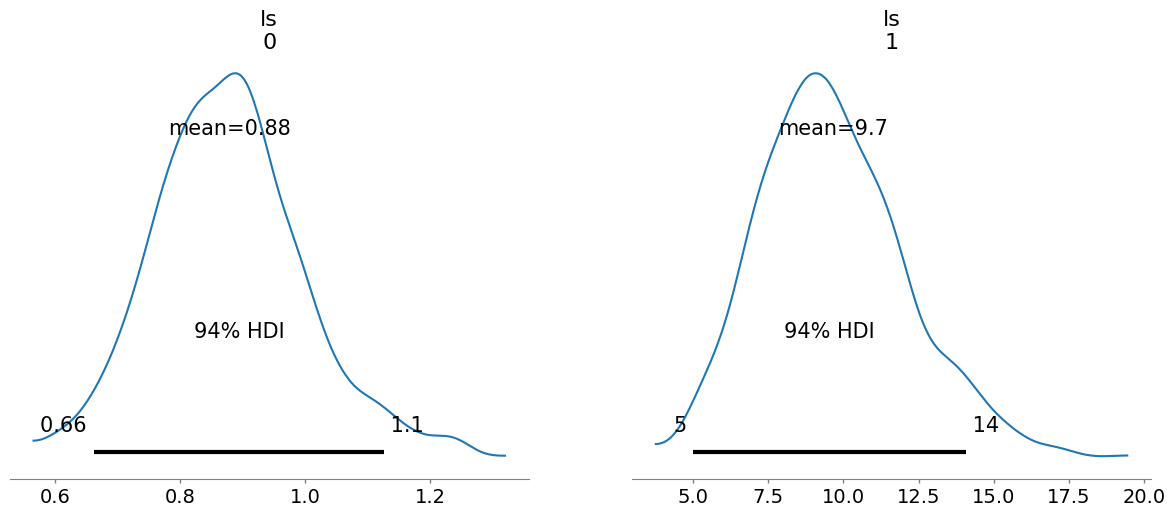

In [24]:
az.plot_posterior(trace_ard, var_names=["ls"])

### Interpretation

Feature 1: small ls → relevant  
Feature 2: large ls → irrelevant

ARD discovered which dimension matters!

### Automating Feature Selection

We just saw that ARD successfully identified which input dimension matters. The ratio of lengthscales tells us how strongly the model believes dimension 2 is irrelevant compared to dimension 1.

In practice, ARD enables **automatic feature selection**: irrelevant dimensions get large lengthscales (model becomes insensitive to them), while important dimensions get small lengthscales (model pays close attention).

Now let's move from multidimensional **inputs** to multiple **outputs**.

## Section 3.7: Comparing All Approaches

We've now explored both sparse GPs and HSGP approximations in detail. Let's bring everything together with a comprehensive comparison that highlights when to use each approach.

### Computational Complexity Summary

Let's visualize the computational complexity of each approach as a function of dataset size.

In [68]:
n_values = np.logspace(2, 4, 50)  # 100 to 10,000 data points
m_sparse = 100  # inducing points
m_hsgp = 100    # basis functions

# Relative computational cost (arbitrary units)
cost_exact = n_values**3 / 1e6  # Scale for visibility
cost_sparse = n_values * m_sparse**2 / 1e6
cost_hsgp = n_values * m_hsgp / 1e6

go.Figure().add_trace(go.Scatter(
    x=n_values,
    y=cost_exact,
    mode='lines',
    name='Exact GP: O(n³)',
    line=dict(color='blue', width=3)
)).add_trace(go.Scatter(
    x=n_values,
    y=cost_sparse,
    mode='lines',
    name=f'Sparse GP: O(nm²), m={m_sparse}',
    line=dict(color='green', width=3)
)).add_trace(go.Scatter(
    x=n_values,
    y=cost_hsgp,
    mode='lines',
    name=f'HSGP: O(nm), m={m_hsgp}',
    line=dict(color='red', width=3)
)).update_layout(
    title='Computational Complexity: Exact GP vs. Approximations',
    xaxis_title='Number of data points (n)',
    yaxis_title='Relative computational cost',
    xaxis_type='log',
    yaxis_type='log',
    height=500,
    showlegend=True,
    hovermode='x unified'
)

### Understanding the Complexity Comparison

This log-log plot dramatically illustrates why approximations are essential for large datasets:

- **The blue line (exact GP)** curves upward steeply, showing the crushing $\mathcal{O}(n^3)$ growth. By $n=10,000$, exact inference is essentially infeasible.

- **The green line (sparse GP)** grows much more slowly at $\mathcal{O}(nm^2)$, making datasets of several thousand points tractable.

- **The red line (HSGP)** has the gentlest slope at $\mathcal{O}(nm)$, showing near-linear scaling that makes even very large datasets manageable.

The crossover points where approximations become worthwhile depend on your patience, hardware, and accuracy requirements, but as a rough guide: consider sparse GPs beyond ~1,000 points and HSGP beyond ~5,000 points.

### Decision Guide: Which Method to Use

Here's practical guidance for choosing between methods:

**Use Standard (Exact) GP when:**
- $n < 1,000$ points
- You need exact inference without approximation error
- You're using non-stationary kernels
- Computation time isn't critical

**Use Sparse GP (Inducing Points) when:**
- $1,000 < n < 10,000$ points  
- Data has uneven sampling density
- You have domain knowledge about where to place inducing points
- You're primarily using Gaussian likelihoods
- **Typical use cases**: Spatial data with known regions of interest, time series with known change points

**Use HSGP when:**
- $n > 5,000$ points
- Using stationary kernels (Matérn, ExpQuad)
- Input dimension is 1, 2, or 3
- You need to integrate the GP into a larger model
- You need predictions at many new locations
- **Typical use cases**: Long time series, spatial data on regular grids, any large dataset with smooth variation

**Practical tip**: When prototyping, start with a low-fidelity HSGP (small $m$) for fast iteration. Once you understand the relevant lengthscales, dial in appropriate $m$ and $c$ for production.